# Data Analysis 3 - Home Assignment 2
## Prediction and analysis script
## Author: Márton Nagy

Make sure that you have run the `MartonNagy_DA3_HA2_data_prep` script before running this.

## Finding fast growing firms

### The assignment

Your task is to build a model to predict fast growth of firms using the bisnode-firms data we used in class.

You should design the target (fast growth), it can be measured in any way you like over one (2013 vs 2012) or two years (2014 vs 2012).
You need to argue for your choice, discussing a few alternatives, maybe 2-3 paragraphs using concepts and ideas from corporate finance.
Build three different models and pick the one you like the most.

Should include at least one logit and one random forest.

### Data management, sample design

- The dataset is very close to what you saw in seminar.
- But you need to start with the panel for 2010-2015.
- Two pieces of code, sample design and prediction:
  - `ch17-firm-exit-data-prep`
  - Starts from `cs_bisnode_panel.csv`
  - Yields `bisnode_firms_clean.csv`
  - `ch17-predicting-firm-exit`.

On the sample, you can make changes, but do not need to.

### Features

- You may use similar variables and features we used for exit prediction.
- You may do differently.
- Look at descriptives, lowess, tabulate factors, make decisions.

### Tasks 1

#### PART I: Probability prediction

- Predict probabilities.
- Look at cross-validated performance and pick your favorite model.

#### PART II: Classification

- Think about the business problem, and define your loss function (like FP=X dollars, FN=Y dollars).
- For each model:
- Predict probabilities.
- Look for the optimal classification threshold.
- Calculate expected loss with your loss function.
- Pick the model that has the smallest average (over 5 folds) expected loss.

#### PART III: Discussion of results

- Show a confusion table (on a selected fold or holdout set).
- Discuss results, evaluate how useful your model may be.

### Tasks 2

- There are two industry categories in the dataset: manufacturing and services (repair, accommodation, food).
- Define a single loss function, but carry out the exercise for two groups separately.
- Pick a prediction model, carry out classification for manufacturing and then repeat for services.
- Compare the model performance across two samples.

### Submit two documents to moodle

- A summary report (pdf), max 5 pages including tables and graphs discussing your work.
  - It is targeted to data science team leaders and senior managers.
  - Can use technical language but explain briefly.
  - But need to be the point!
  - Focus on key decision points, results, interpretation, decision.
- Technical report – a markdown/notebook in pdf/html with more technical discussion.
  - May include code snippets (not verbose, avoid iterations, etc.).
  - May include additional tables and graphs.
  - Detail all decisions you made.
  - Reports should link to code in GitHub.

### Scoring weights

- Task	Weight
- Task 1: Project design, introduction	10%
- Task 1: Data prep, label and feature engineering	15%
- Task 1: Model building and probability prediction and model selection	20%
- Task 1: Classification	15%
- Task 2: Technical execution and write-up	10%
- Discussion of steps, decisions and results	15%
- Explain shortly every modeling decision	
- Final discussion of findings (2-3 paragraphs)	
- Quality of the write-up, prettiness of graphs, etc.	15%

In [2]:
import pandas as pd
import numpy as np
import math
from time import time
from plotnine import *
from IPython.display import display
import patchworklib as pw
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from pathlib import Path
import dill
import json
import warnings
warnings.filterwarnings('ignore')

from utils.py_helper_functions import *

<Figure size 100x100 with 0 Axes>

Read prepared data file.

In [3]:
with open('HA2_workfile.dill', 'rb') as f:
    df = dill.load(f)

Define helper functions (based on case study).

In [ ]:
def cv_summary(lambdas, C_values, model):
    d = {
        'lambdas': lambdas,
        'C_values': C_values,
        'mean_cv_score': model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

    plot = (
        ggplot(all_coords, aes(x='fpr', y='tpr'))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position='identity', fill='mediumaquamarine', alpha=0.3)
        + xlab('False Positive Rate (1-Specifity)')
        + ylab('True Positive Rate (Sensitivity)')
        + geom_abline(intercept=0, slope=1, linetype='dotted', color='black')
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x='thresholds', y='loss'))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom='text',
            x=t - 0.01,
            y=max(all_coords_copy.loss)*0.7,
            label='best threshold: ' + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom='text', x=t + 0.06, y=l, label=f'Loss: {str(round(l, 2))}', size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x='sp', y='se'))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({'sp': [sp], 'se': [se]}))
        + annotate(
            geom='text',
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ', ' + str(round(se, 2)),
            size=7,
        )
        + geom_area(position='identity', fill='mediumaquamarine', alpha=0.3)
        + xlab('False Positive Rate (1-Specifity)')
        + ylab('True Positive Rate (Sensitivity)')
        + geom_abline(intercept=0, slope=1, linetype='dotted', color='black')
        + theme_bw()
    )
    return plot

Dropping foreign and female management columns - will use gender and origin instead.

In [5]:
df.drop(columns=['b_foreign_management', 'b_female_management'], inplace=True)

Dropping EUR sales columns, will use M EUR sales instead.

In [6]:
df.drop(columns = [c for c in df.columns if 'sales' in c and 'sales_mil' not in c], inplace=True)

Make 80-20 train vs. hold-out split.

In [7]:
data_train, data_holdout = train_test_split(df, train_size=0.8, random_state=1234)

Checking whether randomization yielded same proportions in the two parts - seems okay.

In [8]:
print('Total')
print(df['b_fast_growth'].value_counts(normalize=True))
print('Train')
print(data_train['b_fast_growth'].value_counts(normalize=True))
print('Holdout')
print(data_holdout['b_fast_growth'].value_counts(normalize=True))

Total
b_fast_growth
0    0.875184
1    0.124816
Name: proportion, dtype: float64
Train
b_fast_growth
0    0.875033
1    0.124967
Name: proportion, dtype: float64
Holdout
b_fast_growth
0    0.875788
1    0.124212
Name: proportion, dtype: float64


Let's define variable sets for analysis!

In [9]:
# flags created during data cleaning
raw_flags = [c for c in data_train.columns if
             'flag' in c
             and not c.startswith('flag_low_')
             and not c.startswith('flag_high_')] + ['flag_low_ceo_age', 'flag_high_ceo_age']
# categorical variables
categories = [c for c in data_train.columns if c.startswith('f_') and c != 'f_fast_growth']
# binary variables
binary = [c for c in data_train.columns if c.startswith('b_') and c != 'b_fast_growth']
# raw, untransformed variables
raws = [c for c in data_train.columns if
        not c.startswith('ln_')
        and 'flag' not in c
        and not c.endswith('_wins')
        and not c.startswith('d1_')
        and not c.startswith('d2_')
        and not c.startswith('f_')
        and not c.startswith('b_')
        and not c.endswith('_sq')
        and not c.endswith('_cu')
        and c not in ['year', 'comp_id']]
# diffs for non-winsorized variables
non_wins_diffs = [c for c in data_train.columns if
                  (c.startswith('d1_') or c.startswith('d2_'))
                  and not c.endswith('_wins')
                  and not c.endswith('_sq')
                  and not c.endswith('_cu')]
# temporary
squares = [c for c in data_train.columns if c.endswith('_sq')]
cubes = [c for c in data_train.columns if c.endswith('_cu')]
h = [c[:-3] for c in squares]

# numeric columns (winsorized if applicable)
numerics = [c for c in h if 'ln_' + c not in h]
# squares and cubes of numeric columns
squares = [c + '_sq' for c in numerics]
cubes = [c + '_cu' for c in numerics]
# flags created during winsorization
h2 = ['flag_high_' + c.replace('_wins', '') for c in numerics] + ['flag_low_' + c.replace('_wins', '') for c in numerics]
wins_flags = [c for c in h2 if c in data_train.columns]

Defining a very broad set of interaction terms for LASSO logit.

In [10]:
interactions = [
    'C(f_ind2_cat)*age_wins',
    'C(f_ind2_cat)*age_wins_sq',
    'C(f_ind2_cat)*age_wins_cu',
    'C(f_ind2_cat)*ceo_age',
    'C(f_ind2_cat)*ceo_age_sq',
    'C(f_ind2_cat)*ceo_age_cu',
    'C(f_ind2_cat)*C(f_origin)',
    'C(f_ind2_cat)*C(f_gender)',
    'C(f_ind2_cat)*C(f_urban_m)',
    'C(f_ind2_cat)*labor_avg_mod',

    '(ln_sales_mil_wins+d1_ln_sales_mil_wins+d2_ln_sales_mil_wins)'+\
    '*(age_wins+age_wins_sq+age_wins_cu+ceo_age+ceo_age_sq+ceo_age_cu+'+\
    'C(f_ind2_cat)+C(f_gender)+C(f_origin)+C(f_urban_m))',

    '(ln_total_assets_wins+d1_ln_total_assets_wins+d2_ln_total_assets_wins)'+\
    '*(age_wins+age_wins_sq+age_wins_cu+ceo_age+ceo_age_sq+ceo_age_cu+'+\
    'C(f_ind2_cat)+C(f_gender)+C(f_origin)+C(f_urban_m))',

    '(profit_loss_year_wins+d1_profit_loss_year_wins+d2_profit_loss_year_wins)'+\
    '*(age_wins+age_wins_sq+age_wins_cu+ceo_age+ceo_age_sq+ceo_age_cu+'+\
    'C(f_ind2_cat)+C(f_gender)+C(f_origin)+C(f_urban_m))',

    'ln_sales_mil_wins*ln_total_assets_wins',
    'ln_sales_mil_wins*profit_loss_year_wins',
    'ln_total_assets_wins*profit_loss_year_wins',

    'd1_ln_sales_mil_wins*d1_ln_total_assets_wins',
    'd1_ln_sales_mil_wins*d1_profit_loss_year_wins',
    'd1_ln_total_assets_wins*d1_profit_loss_year_wins',

    'd2_ln_sales_mil_wins*d2_ln_total_assets_wins',
    'd2_ln_sales_mil_wins*d2_profit_loss_year_wins',
    'd2_ln_total_assets_wins*d2_profit_loss_year_wins',
]

In [11]:
lasso_vars = numerics + squares + cubes + raw_flags + wins_flags + categories + binary + interactions
tree_vars = raws + non_wins_diffs + raw_flags + categories + binary

Instantiate 5-fold CV method so that we can use the same folds to CV models across different approaches.

In [12]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

Dictionary for model times.

In [ ]:
#use this if running for the first time
'''
model_times = {
    'lasso_logit' : -9,
    'prob_forest' : -9,
    'prob_xgb' : -9
}
'''

In [ ]:
# use this if only re-running certain models (the other models' time won't be lost this way)
with open("model_times.json", "r", encoding="utf-8") as f:
    model_times = json.load(f)

Estimating LASSO logit models. Due to technical constraints, I have to estimate the Brier-score version and the AUC version separetly. As `refit` is set to `True`, the best model according to the set scoring metric is re-estimated on the whole train sample.

In [17]:
lasso_model_equation = 'b_fast_growth~' + '+'.join(lasso_vars)
y_train_lasso, X_train_lasso = patsy.dmatrices(lasso_model_equation, data_train)

lasso_scaler = StandardScaler().fit(X_train_lasso)
X_train_lasso_scaled = pd.DataFrame(lasso_scaler.transform(X_train_lasso), columns=X_train_lasso.design_info.column_names)

lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = X_train_lasso_scaled.shape[0] * 4 / 5
C_values = [1 / (l * n_obs) for l in lambdas]

lasso_model_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty='l1',
    cv=k,
    refit=True,
    scoring='neg_brier_score',
    solver='saga',
    random_state=42,
    n_jobs=-1
)

lasso_model_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty='l1',
    cv=k,
    refit=True,
    scoring='roc_auc',
    solver='saga',
    random_state=42,
    n_jobs=-1
)

# The training time is not the sum of the training with the two metrics - it is just a technical detail
# that LogisticRegressionCV is cannot estimate two scoring metrics at once.
start_time = time()
lasso_brier = lasso_model_brier.fit(X_train_lasso_scaled, y_train_lasso)
timespan = time() - start_time
model_times['lasso_logit'] = timespan

lasso_auc = lasso_model_auc.fit(X_train_lasso_scaled, y_train_lasso)

In [21]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "lasso_brier.dill"), "wb") as f:
    dill.dump(lasso_brier, f)
with open(Path("model_dills", "lasso_auc.dill"), "wb") as f:
    dill.dump(lasso_auc, f)

In [30]:
tree_model_equation = 'b_fast_growth~' + '+'.join(tree_vars)
y_train_tree, X_train_tree = patsy.dmatrices(tree_model_equation, data_train)
X_train_tree = pd.DataFrame(X_train_tree, columns=X_train_tree.design_info.column_names)
X_train_tree = X_train_tree.drop(columns=['Intercept'])
X_train_tree.columns = [col.replace("[", "(").replace("]", ")").replace("<", "") for col in X_train_tree.columns]
y_train_tree = pd.DataFrame(y_train_tree, columns=y_train_tree.design_info.column_names)

In [34]:
grid = {
    "max_features": [9, 11, 13, 15],
    "criterion": ["gini"],
    "min_samples_split": [10, 15, 20, 25],
}

prob_forest = RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    oob_score=True,
    n_jobs=-1
    )
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
    verbose=0,
    n_jobs=-1
)

start_time = time()
prob_forest_fit = prob_forest_grid.fit(X_train_tree, y_train_tree)
timespan = time() - start_time
model_times['prob_forest'] = timespan

In [35]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "prob_forest.dill"), "wb") as f:
    dill.dump(prob_forest_fit, f)

Tuning the XGBoost classifier was a bit tricky because of computational constraints. As a workaround, first, I do a grid search of hyperparameter candidates with HalvingGridSearchCV, a lower number of boosting rounds and only 3 fold CV. Then I will do a regular CV gridsearch with only the most prospective parameters, but now with 5 fold CV and an increased number of boosting rounds. As `resource` is `n_samples` by default, and `cv` uses no shuffle, there is no randomness, the results are reproducible (as per the docs).

In [45]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
grid_xgb = {
    "max_depth": [4, 6, 8, 10],  
    "colsample_bytree": [0.2, 0.3, 0.5, 0.7],   
    "learning_rate": [0.03, 0.05, 0.1],
    "min_child_weight": [5, 10, 15],
    "subsample": [0.2, 0.6, 1],
    "gamma": [0, 0.1, 0.3],
}

prob_xgb = XGBClassifier(
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='rmse', #Gini is not available in XGBoost, but RMSE should yield the same results
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=0
    )

prob_xgb_grid = HalvingGridSearchCV(
    prob_xgb,
    grid_xgb,
    cv=3,
    factor=3,
    refit=False,
    scoring='roc_auc',
    verbose=0,
    n_jobs=-1
)

start_time = time()
prob_xgb_fit = prob_xgb_grid.fit(X_train_tree, y_train_tree)
timespan = time() - start_time
model_times['prob_xgb'] = timespan

In [57]:
prob_xgb_fit.best_params_

{'colsample_bytree': 0.2,
 'gamma': 0,
 'learning_rate': 0.03,
 'max_depth': 8,
 'min_child_weight': 5,
 'subsample': 1}

I now reduce the training grid based on the best parameters found by HalvingGridSearchCV, but I increase the number of boosting rounds and the folds used for CV.

In [58]:
grid_xgb = {
    "max_depth": [7, 8, 9],  
    "colsample_bytree": [0.1, 0.2],   
    "learning_rate": [0.02, 0.03],
    "min_child_weight": [3, 5],
    "subsample": [0.8, 1],
    "gamma": [0, 0.1],
}

prob_xgb = XGBClassifier(
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='rmse', #Gini is not available in XGBoost, but RMSE should yield the same results
    n_estimators=500, # increased number of boosting rounds
    random_state=42,
    n_jobs=-1,
    verbose=0
    )

prob_xgb_grid = GridSearchCV(
    prob_xgb,
    grid_xgb,
    cv=k, # using the same 5-fold cross-validation as for the other models
    refit='roc_auc', # refitting the model with the best parameters for ROC AUC
    scoring=['roc_auc', 'neg_brier_score'], # calculating both neeeded metrics
    verbose=0,
    n_jobs=-1
)

start_time = time()
prob_xgb_fit = prob_xgb_grid.fit(X_train_tree, y_train_tree)
timespan += time() - start_time # adding the time for the second grid search
model_times['prob_xgb'] = timespan

In [63]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "prob_xgb.dill"), "wb") as f:
    dill.dump(prob_xgb_fit, f)

# RUN FROM HERE FOR SAVED MODEL FILES

In [64]:
with open("model_times.json", "r", encoding="utf-8") as f:
    model_times = json.load(f)

In [65]:
with open(Path("model_dills", "lasso_brier.dill"), "rb") as f:
    lasso_brier = dill.load(f)
with open(Path("model_dills", "lasso_auc.dill"), "rb") as f:
    lasso_auc = dill.load(f)
with open(Path("model_dills", "prob_forest.dill"), "rb") as f:
    prob_forest = dill.load(f)
with open(Path("model_dills", "prob_xgb.dill"), "rb") as f:
    prob_xgb = dill.load(f)

## Model performance for predicting probabilities

Now let's look at model performance. First, I will examine the tuning grids.

For the LASSO logit model, we can see that both metrics (RMSE and AUC) point to the same lambda value: 0.002154 - we can see this visually as well.

In [67]:
cv_summary_lasso = cv_summary(lambdas, C_values, lasso_brier)
cv_summary_lasso['mean_cv_score'] = np.sqrt(cv_summary_lasso['mean_cv_score'] * -1)
cv_lasso_auc = cv_summary(lambdas, C_values, lasso_auc)
cv_lasso_auc.rename(columns={'mean_cv_score': 'mean_cv_auc'}, inplace=True)
cv_summary_lasso = cv_summary_lasso.merge(cv_lasso_auc, on=['lambdas', 'C_values'])
cv_summary_lasso.columns = ['Lambda', 'C value', 'Mean CV RMSE', 'Mean CV AUC']
cv_summary_lasso

,Lambda,C value,Mean CV RMSE,Mean CV AUC
0,0.100000,0.000821,0.337187,0.500000
1,0.046416,0.001768,0.326813,0.672180
2,0.021544,0.003810,0.319522,0.705186
3,0.010000,0.008209,0.315212,0.732120
4,0.004642,0.017685,0.312997,0.743851
5,0.002154,0.038101,0.312113,0.748312
6,0.001000,0.082086,0.312687,0.746036
7,0.000464,0.176848,0.313807,0.742327
8,0.000215,0.381008,0.314846,0.739122
9,0.000100,0.820856,0.315650,0.736463


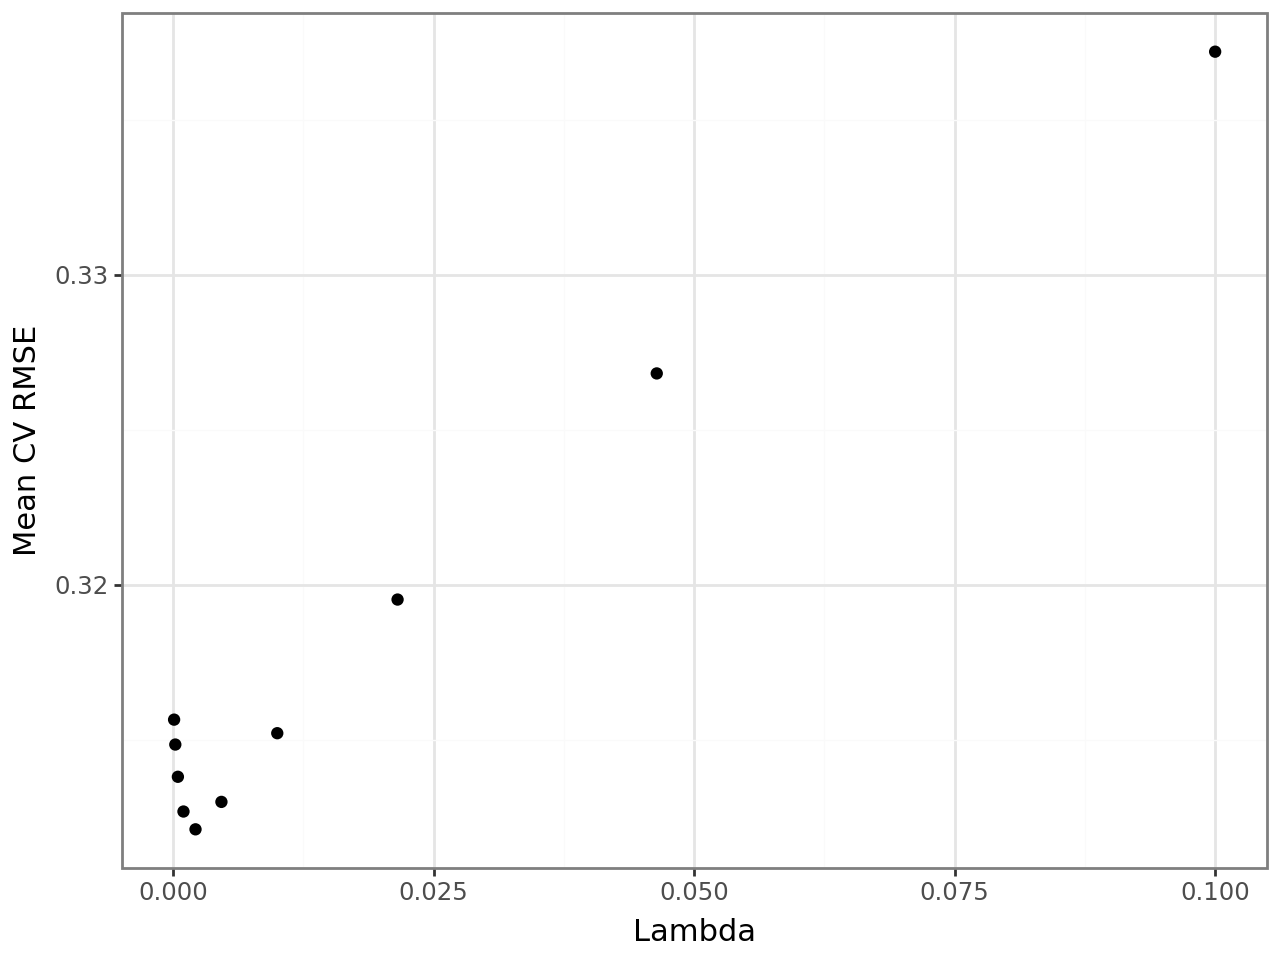

In [68]:
(
    ggplot(cv_summary_lasso, aes(x="Lambda", y="Mean CV RMSE"))
    + geom_point()
    + theme_bw()
)

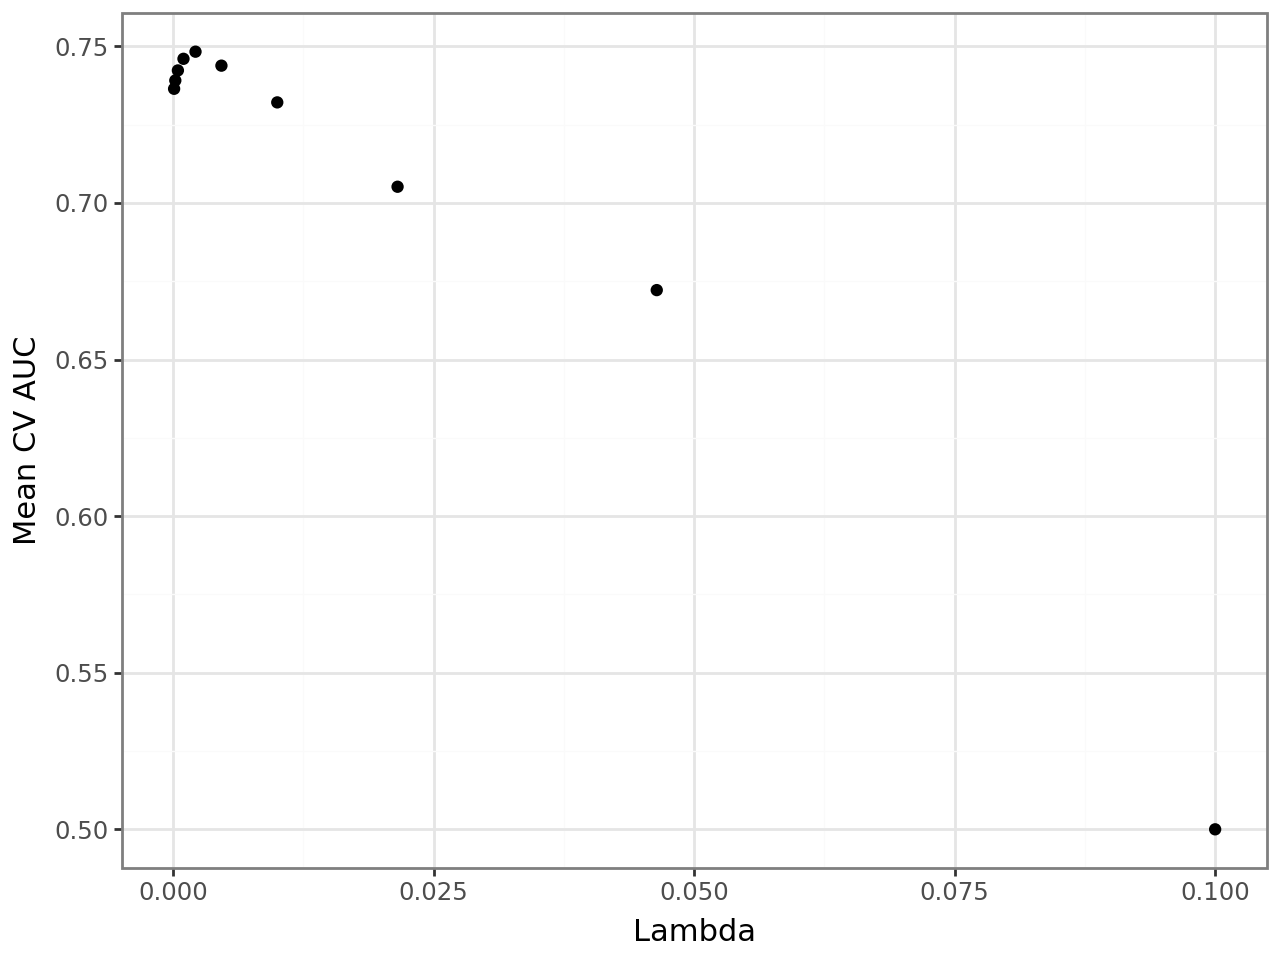

In [69]:
(
    ggplot(cv_summary_lasso, aes(x="Lambda", y="Mean CV AUC"))
    + geom_point()
    + theme_bw()
)

For the probability forest, we can see that for the CV RMSE, many parameter values yield practically the same results. However, looking out AUC, we have a clearly better combination of the tuning grid. Note however, that these values are only marginally better than the LASSO logit results.

*Note: on both heatmaps, dark purple colors indicate better results (lower RMSE or higher AUC).*

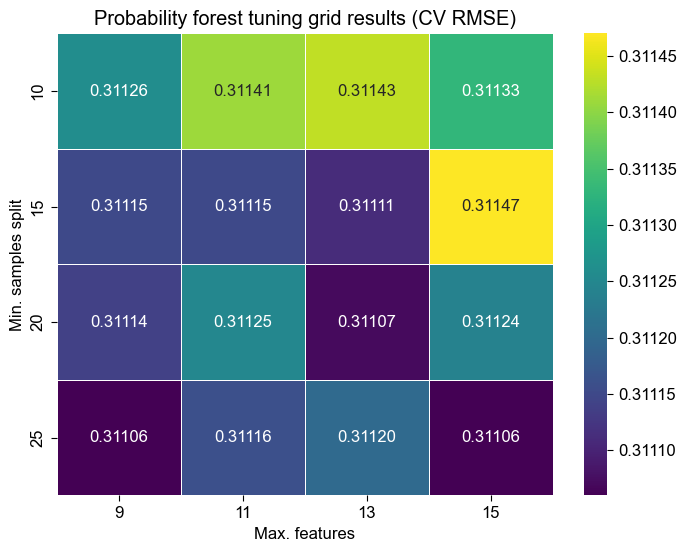

In [85]:
heatmap_data = pd.DataFrame(prob_forest.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_neg_brier_score"]
].assign(
    mean_test_score=lambda x: np.sqrt(x["mean_test_neg_brier_score"] * -1),
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(5)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".5f", linewidths=0.5)

plt.xlabel("Max. features")
plt.ylabel("Min. samples split")
plt.title("Probability forest tuning grid results (CV RMSE)")

plt.show()

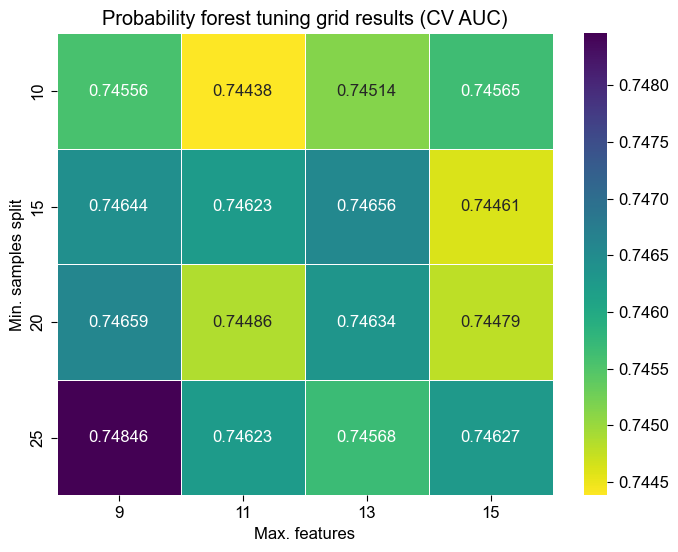

In [86]:
heatmap_data = pd.DataFrame(prob_forest.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_roc_auc"]
].assign(
    mean_test_score=lambda x: x["mean_test_roc_auc"],
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(5)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis_r", fmt=".5f", linewidths=0.5)

plt.xlabel("Max. features")
plt.ylabel("Min. samples split")
plt.title("Probability forest tuning grid results (CV AUC)")

plt.show()

For the probability XGBoost model, we can observe that there is a small discrepancy between whether we score the models by RMSE or AUC. As our end-goal is classification, I will rely on the AUC values. Nonetheless, note that XGBoost means a notable improvement compared to the LASSO logit and the probability forest, both in terms of RMSE and AUC.

In [90]:
xgb_grid_results = pd.DataFrame(prob_xgb.cv_results_)[[
    "mean_test_neg_brier_score",
    "mean_test_roc_auc",
    "param_colsample_bytree",
    "param_learning_rate",
    "param_max_depth",
    "param_min_child_weight",
    "param_subsample",
    "param_gamma"
]].astype(float)

xgb_grid_results.mean_test_neg_brier_score = np.sqrt(xgb_grid_results.mean_test_neg_brier_score * -1)

xgb_grid_results.sort_values(by = 'mean_test_roc_auc', ascending = False, inplace = True)

xgb_grid_results.columns = ['CV RMSE', 'CV AUC', 'Col. subsample ratio', 'Learning rate', 'Max. depth', 'Min. child weight', 'Subsampling ratio', 'Gamma']

xgb_grid_results.reset_index(drop = True, inplace = True)

xgb_grid_results

,CV RMSE,CV AUC,Col. subsample ratio,Learning rate,Max. depth,Min. child weight,Subsampling ratio,Gamma
0,0.308045,0.766169,0.2,0.02,7.0,5.0,1.0,0.0
1,0.308108,0.765723,0.2,0.02,7.0,5.0,1.0,0.1
2,0.308020,0.765645,0.2,0.02,7.0,5.0,0.8,0.1
3,0.308312,0.765584,0.2,0.02,7.0,3.0,1.0,0.1
4,0.308021,0.765316,0.2,0.02,7.0,5.0,0.8,0.0
...,...,...,...,...,...,...,...,...
91,0.311144,0.756531,0.1,0.03,9.0,3.0,0.8,0.1
92,0.311018,0.756485,0.1,0.03,9.0,3.0,0.8,0.0
93,0.310581,0.755787,0.1,0.03,9.0,5.0,1.0,0.0
94,0.311694,0.755461,0.1,0.03,9.0,3.0,1.0,0.1


Now let's compare the cross-validated performance of the best of all three models.

In [102]:
cv_all_results = pd.DataFrame({
    'LASSO logit' : {
        'CV RMSE' : round(cv_summary_lasso['Mean CV RMSE'].min(), 4),
        'CV AUC' : round(cv_summary_lasso['Mean CV AUC'].max(), 4),
        'Time (min)' : round(model_times['lasso_logit'] / 60, 2)
    },
    'Prob. forest' : {
        'CV RMSE' : round(np.sqrt(prob_forest.cv_results_['mean_test_neg_brier_score'][prob_forest.cv_results_['mean_test_roc_auc'].argmax()]*-1), 4),
        'CV AUC' : round(prob_forest.cv_results_['mean_test_roc_auc'].max(), 4),
        'Time (min)' : round(model_times['prob_forest'] / 60, 2)
    },
    'Prob. XGB' : {
        'CV RMSE' : round(np.sqrt(prob_xgb.cv_results_['mean_test_neg_brier_score'][prob_xgb.cv_results_['mean_test_roc_auc'].argmax()]*-1), 4),
        'CV AUC' : round(prob_xgb.cv_results_['mean_test_roc_auc'].max(), 4),
        'Time (min)' : round(model_times['prob_xgb'] / 60, 2)
    }
}).T
cv_all_results

,CV RMSE,CV AUC,Time (min)
LASSO logit,0.3121,0.7483,2.99
Prob. forest,0.3111,0.7485,11.29
Prob. XGB,0.3080,0.7662,20.86


We can also look at the hold-out set performance of the models.

In [ ]:
# you only need to run this if working with pre-saved models
lasso_model_equation = 'b_fast_growth~' + '+'.join(lasso_vars)
y_train_lasso, X_train_lasso = patsy.dmatrices(lasso_model_equation, data_train)
lasso_scaler = StandardScaler().fit(X_train_lasso)
X_train_lasso_scaled = pd.DataFrame(lasso_scaler.transform(X_train_lasso), columns=X_train_lasso.design_info.column_names)

tree_model_equation = 'b_fast_growth~' + '+'.join(tree_vars)
y_train_tree, X_train_tree = patsy.dmatrices(tree_model_equation, data_train)
X_train_tree = pd.DataFrame(X_train_tree, columns=X_train_tree.design_info.column_names)
X_train_tree = X_train_tree.drop(columns=['Intercept'])
X_train_tree.columns = [col.replace("[", "(").replace("]", ")").replace("<", "") for col in X_train_tree.columns]
y_train_tree = pd.DataFrame(y_train_tree, columns=y_train_tree.design_info.column_names)

Using the same standard scaler for LASSO as on the training set to avoid leaking information from the hold-out set.

In [103]:
y_hold_lasso, X_hold_lasso = patsy.dmatrices(lasso_model_equation, data_holdout)
X_hold_lasso_scaled = pd.DataFrame(lasso_scaler.transform(X_hold_lasso), columns=X_hold_lasso.design_info.column_names)

In [104]:
y_hold_tree, X_hold_tree = patsy.dmatrices(tree_model_equation, data_holdout)
X_hold_tree = pd.DataFrame(X_hold_tree, columns=X_hold_tree.design_info.column_names)
X_hold_tree = X_hold_tree.drop(columns=['Intercept'])
X_hold_tree.columns = [col.replace("[", "(").replace("]", ")").replace("<", "") for col in X_hold_tree.columns]
y_hold_tree = pd.DataFrame(y_hold_tree, columns=y_hold_tree.design_info.column_names)

As all the models have been already refitted on the whole training sample by the CV algorithms, we can simply call the prediction function on those objects.

In [108]:
hold_out_predictions = pd.DataFrame({
    'b_fast_growth_true' : y_hold_lasso.ravel(),
    'lasso_pred' : lasso_auc.predict_proba(X_hold_lasso_scaled)[:, 1],
    'rf_pred' : prob_forest.predict_proba(X_hold_tree)[:, 1],
    'xgb_pred' : prob_xgb.predict_proba(X_hold_tree)[:, 1]
})

In [106]:
hold_out_predictions

,b_fast_growth_true,lasso_pred,rf_pred,xgb_pred
28796,0,0.292455,0.193220,0.275495
127226,0,0.041367,0.017656,0.025029
92312,0,0.159716,0.134950,0.100248
74774,1,0.314143,0.157345,0.158542
14804,0,0.028305,0.056341,0.020356
...,...,...,...,...
197066,0,0.031708,0.131504,0.018186
132566,0,0.235333,0.121719,0.222143
7292,0,0.049560,0.057996,0.095906
90428,0,0.058343,0.007838,0.040079


In [114]:
hold_out_metrics = pd.DataFrame({
    'LASSO logit' : {
        'Hold-out RMSE' : mean_squared_error(hold_out_predictions['b_fast_growth_true'], hold_out_predictions['lasso_pred'], squared=False).round(4),
        'Hold-out AUC' : roc_auc_score(hold_out_predictions['b_fast_growth_true'], hold_out_predictions['lasso_pred']).round(4)
    },
    'Prob. forest' : {
        'Hold-out RMSE' : mean_squared_error(hold_out_predictions['b_fast_growth_true'], hold_out_predictions['rf_pred'], squared=False).round(4),
        'Hold-out AUC' : roc_auc_score(hold_out_predictions['b_fast_growth_true'], hold_out_predictions['rf_pred']).round(4)
    },
    'Prob. XGB' : {
        'Hold-out RMSE' : mean_squared_error(hold_out_predictions['b_fast_growth_true'], hold_out_predictions['xgb_pred'], squared=False).round(4),
        'Hold-out AUC' : roc_auc_score(hold_out_predictions['b_fast_growth_true'], hold_out_predictions['xgb_pred']).round(4)
    }
}).T

In [116]:
prob_summary = cv_all_results.merge(hold_out_metrics, left_index=True, right_index=True)
prob_summary = prob_summary.filter(['CV RMSE', 'Hold-out RMSE', 'CV AUC', 'Hold-out AUC', 'Time (min)'])
prob_summary

,CV RMSE,Hold-out RMSE,CV AUC,Hold-out AUC,Time (min)
LASSO logit,0.3121,0.3118,0.7483,0.7444,2.99
Prob. forest,0.3111,0.3096,0.7485,0.7446,11.29
Prob. XGB,0.3080,0.3060,0.7662,0.7627,20.86


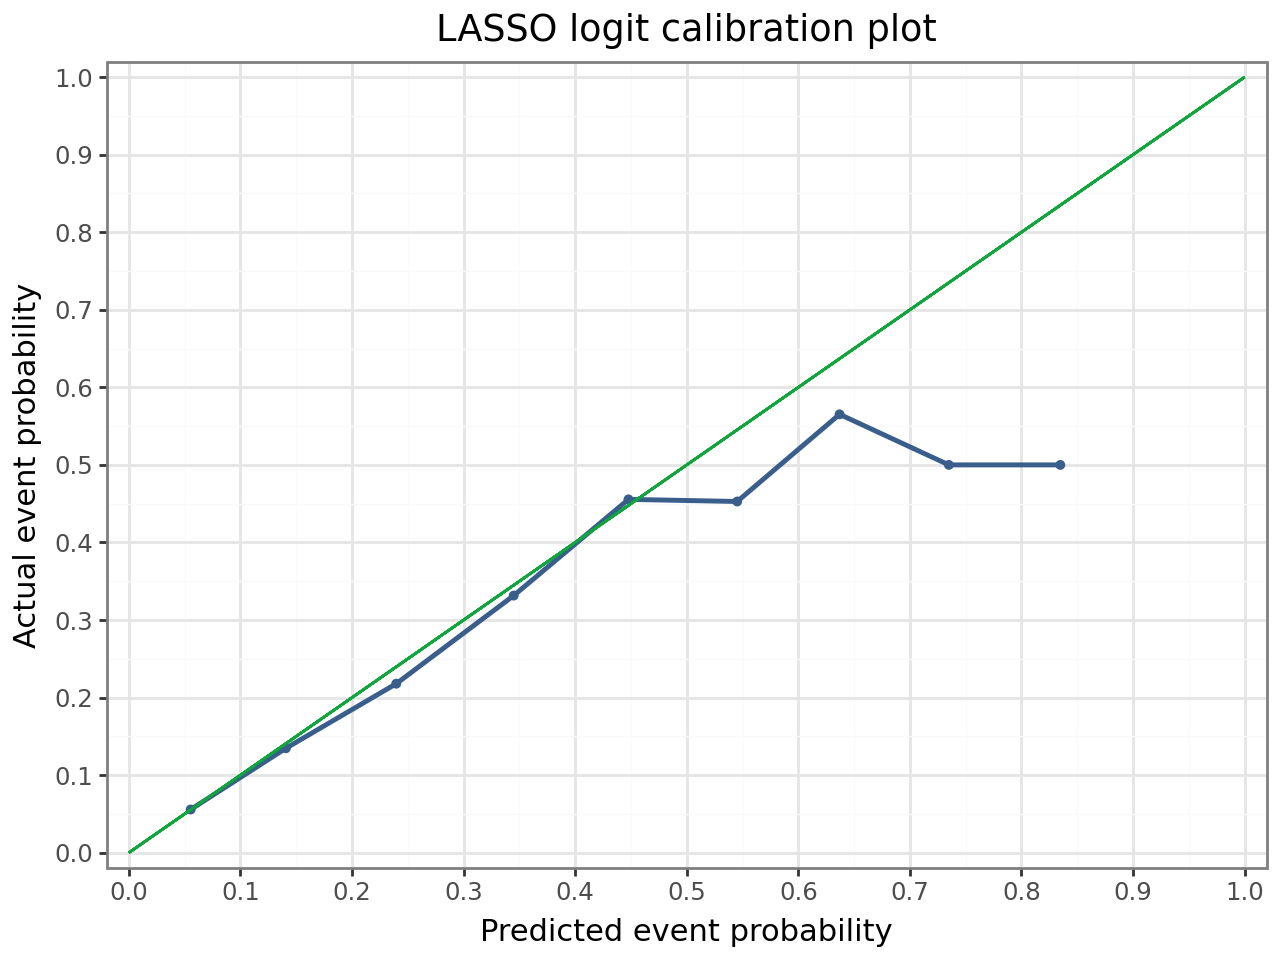

In [119]:
create_calibration_plot(
    hold_out_predictions,
    file_name='NA',
    prob_var="lasso_pred",
    actual_var="b_fast_growth_true",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
) + labs(title="LASSO logit calibration plot")

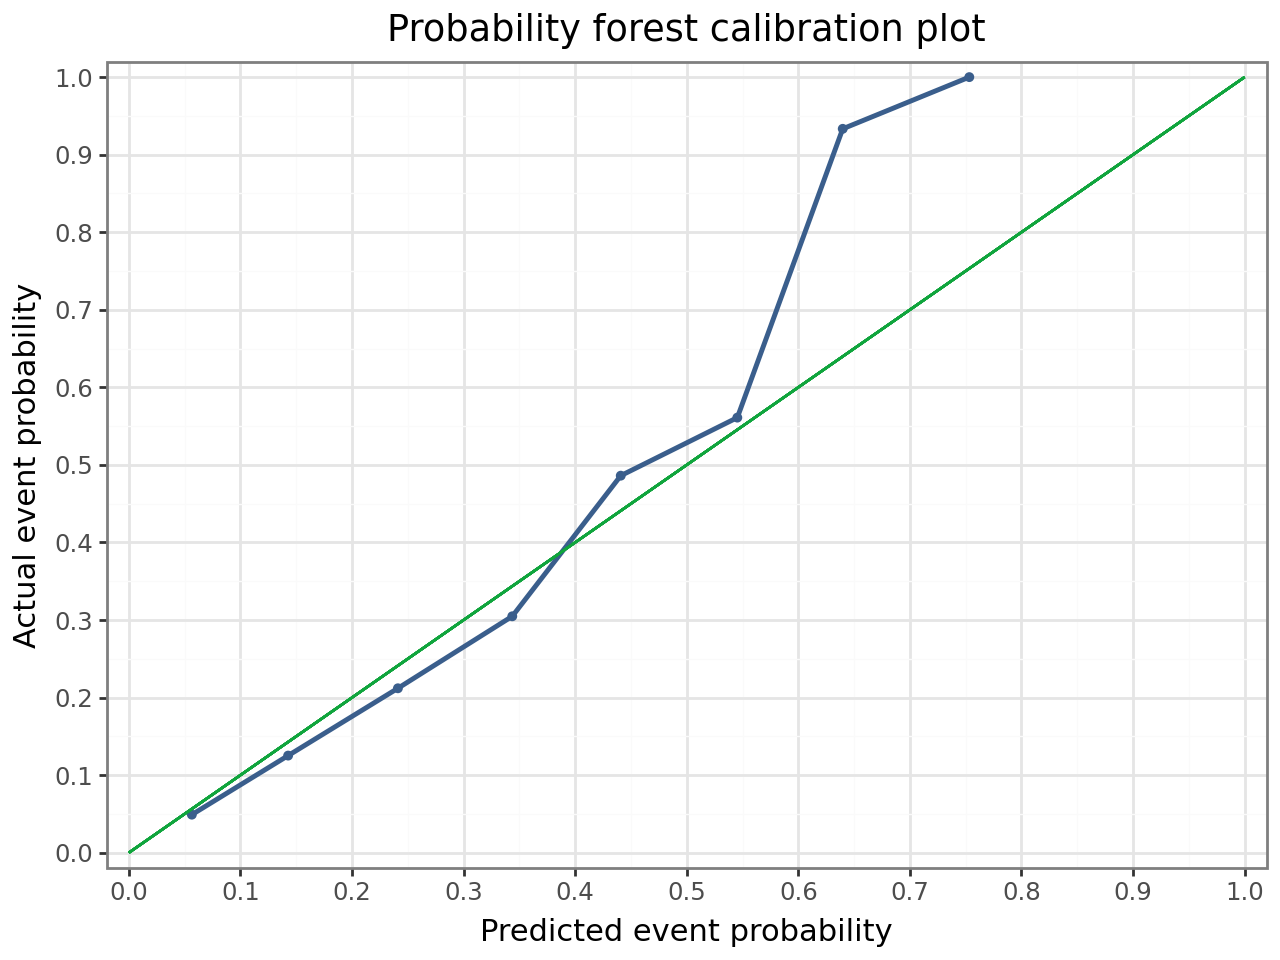

In [127]:
create_calibration_plot(
    hold_out_predictions,
    file_name='NA',
    prob_var="rf_pred",
    actual_var="b_fast_growth_true",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
) + labs(title="Probability forest calibration plot")

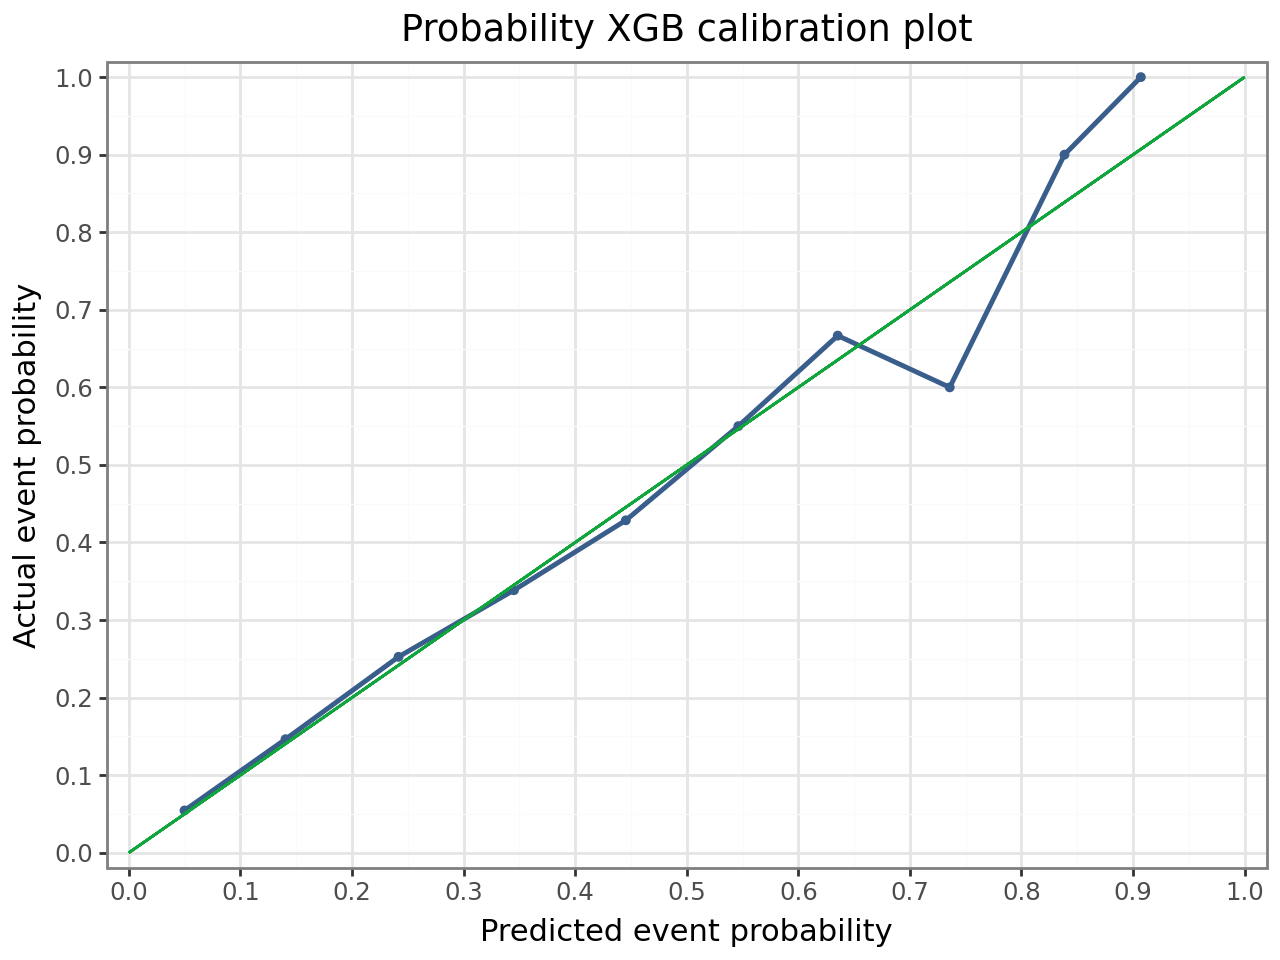

In [121]:
create_calibration_plot(
    hold_out_predictions,
    file_name='NA',
    prob_var="xgb_pred",
    actual_var="b_fast_growth_true",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
) + labs(title="Probability XGB calibration plot")

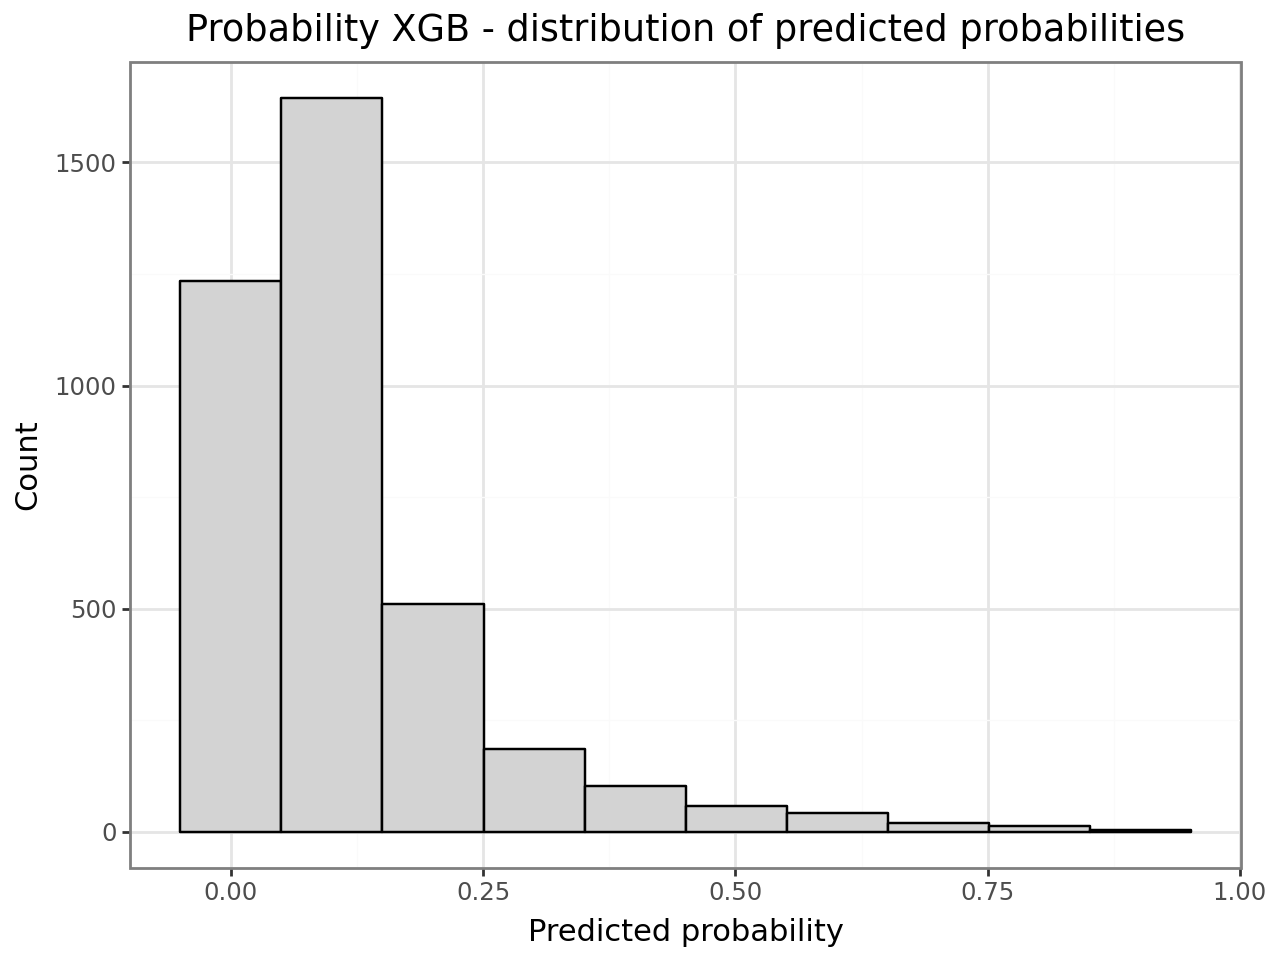

In [133]:
(
    ggplot(hold_out_predictions, aes(x="xgb_pred"))
    + geom_histogram(fill = 'lightgrey', color = 'black', bins = 10)
    + theme_bw()
    + labs(title="Probability XGB - distribution of predicted probabilities",
           x="Predicted probability",
           y="Count")
)

## Classification performance

First, let's define our loss function. Imagine that we are running a VC or PE fund, and would want to know in which firms to put our money. We know that there are relatively few fast growth firms out there, so we would like to capture as many of them as possible - even if that means that we will put at least part of our money in bad-performing companies.

This means that a false negative is more costly for us (as we miss capitalizing on potentially extreme growth) than a false positive (where we only lose our invested capital (or just a part of it), which is not a lot compared to the fund sizes in the industry).

But how much exactly the cost difference? Consider an investment of a thousand USD. As the mean 2-year CAGR in the sample was around 40% for 2012, we may think of fast growing firms as those that have around a 50% CAGR. Over two years, this means a 125% growth of the invested capital, or 1250 USD profit on the 1000 USD invested. We would lose the opportunity of around this much profit in the case of a false negative classification. Now let's think about the other case. We invest in a firm 1000 USD that turns out to be underperforming, or worse, it may even go bankrupt. So the most we can lose is a 1000 USD (in the case of bankruptcy), but it would be rather conservative that we would always lose this much, as some firms may be just below our fast-growth threshold. For simplicity, let's assume a loss of 250 USD for false negatives. Thus, our false negative / false positive rate comes out to be 5-to-1.

In [134]:
# Model predicts fast growth, but the firm is rather slow-growth or will default.
FP = 1
# Model predicts no fast growth, but the firm is actually fast-growing.
FN = 5
cost = FN / FP

In [142]:
prevelance = float(np.sum(y_train_tree) / len(y_train_tree))

In [153]:
best_models = {
    'lasso_logit' : LogisticRegression(
        penalty='l1',
        C=cv_summary_lasso['C value'].iloc[cv_summary_lasso['Mean CV AUC'].argmax()],
        solver='saga',
        random_state=42,
        n_jobs=-1
    ),
    'prob_forest' : RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        n_jobs=-1,
        criterion=prob_forest.best_params_['criterion'],
        max_features=prob_forest.best_params_['max_features'],
        min_samples_split=prob_forest.best_params_['min_samples_split']
    ),
    'prob_xgb' : XGBClassifier(
        tree_method='hist',
        objective='binary:logistic',
        eval_metric='rmse',
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        colsample_bytree=prob_xgb.best_params_['colsample_bytree'],
        gamma=prob_xgb.best_params_['gamma'],
        learning_rate=prob_xgb.best_params_['learning_rate'],
        max_depth=prob_xgb.best_params_['max_depth'],
        min_child_weight=prob_xgb.best_params_['min_child_weight'],
        subsample=prob_xgb.best_params_['subsample']
    )
}

In [ ]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for model_name, estimator in best_models.items():
    best_thresholds = []
    expected_loss = []

    # setting appropriate RHS variables for different models
    if model_name == 'lasso_logit':
        X = X_train_lasso_scaled
    else:
        X = X_train_tree
    
    fold = 0
    # cross-validation
    for train_index, test_index in k.split(X):
        
        # train and test split for the fold
        X_fold_test = X.iloc[test_index, :]
        y_fold_test = data_train['b_fast_growth'].iloc[test_index]

        X_fold_train = X.iloc[train_index, :]
        y_fold_train = data_train['b_fast_growth'].iloc[train_index]

        # fit model on fold
        fitted_estimator = estimator.fit(X_fold_train, y_fold_train)

        # make prediction on fold test data
        pred_fold = fitted_estimator.predict_proba(X_fold_test)[:, 1]

        #calculate ROC curve values
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold_test, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(true_pos_rate + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]

        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)

        tn, fp, fn, tp = confusion_matrix(
            y_fold_test, threshold_prediction, labels=[0, 1]
        ).ravel()

        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold_test)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold_test == 0),
            "true_pos": true_pos_rate * sum(y_fold_test == 1),
            "false_neg": sum(y_fold_test == 1) - true_pos_rate * sum(y_fold_test == 1),
            "true_neg": sum(y_fold_test == 0) - false_pos_rate * sum(y_fold_test == 0),
            "pos": sum(y_fold_test == 1),
            "neg": sum(y_fold_test == 0),
            "n": len(y_fold_test),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [189]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model_raw", "Avg. of optimal thresholds"]
)
summary_with_lossfnc["Threshold for 5th fold"] = fold5_threshold.values()
summary_with_lossfnc["Avg. expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for 5th fold"] = fold5_expected_loss.values()
summary_with_lossfnc['Model'] = ['LASSO logit', 'Prob. forest', 'Prob. XGB']
summary_with_lossfnc.drop(columns=['Model_raw'], inplace=True)
summary_with_lossfnc = summary_with_lossfnc.filter(['Model'] + list(summary_with_lossfnc.columns)[:-1])
summary_with_lossfnc


,Model,Avg. of optimal thresholds,Threshold for 5th fold,Avg. expected loss,Expected loss for 5th fold
0,LASSO logit,0.18680,0.150095,0.448645,0.450246
1,Prob. forest,0.20146,0.200143,0.453374,0.460427
2,Prob. XGB,0.14854,0.140752,0.436759,0.420690


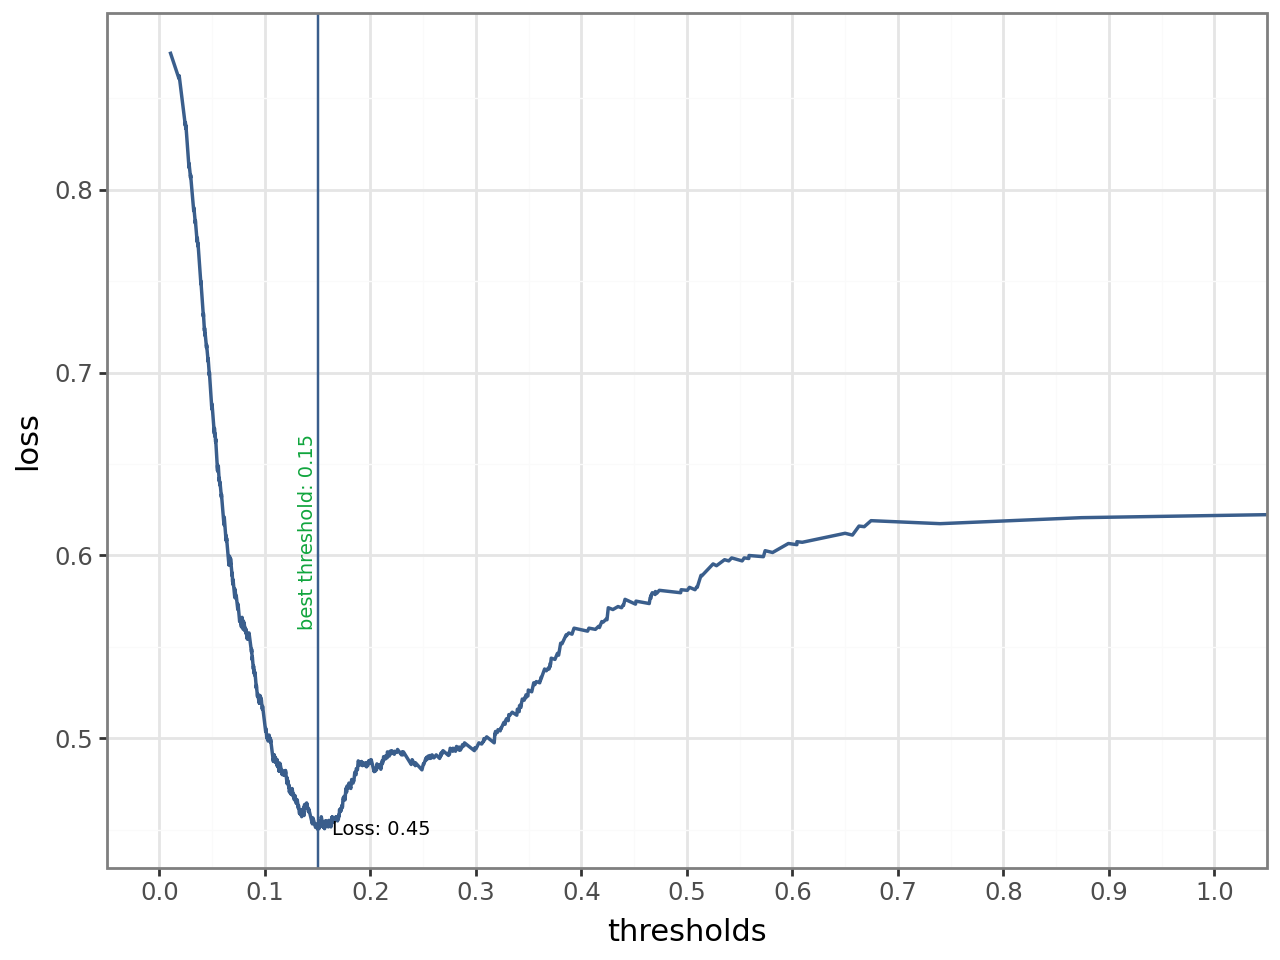

In [174]:
create_loss_plot(
    fold5_all_coords['lasso_logit'],
    fold5_threshold['lasso_logit'],
    fold5_expected_loss['lasso_logit'],
)


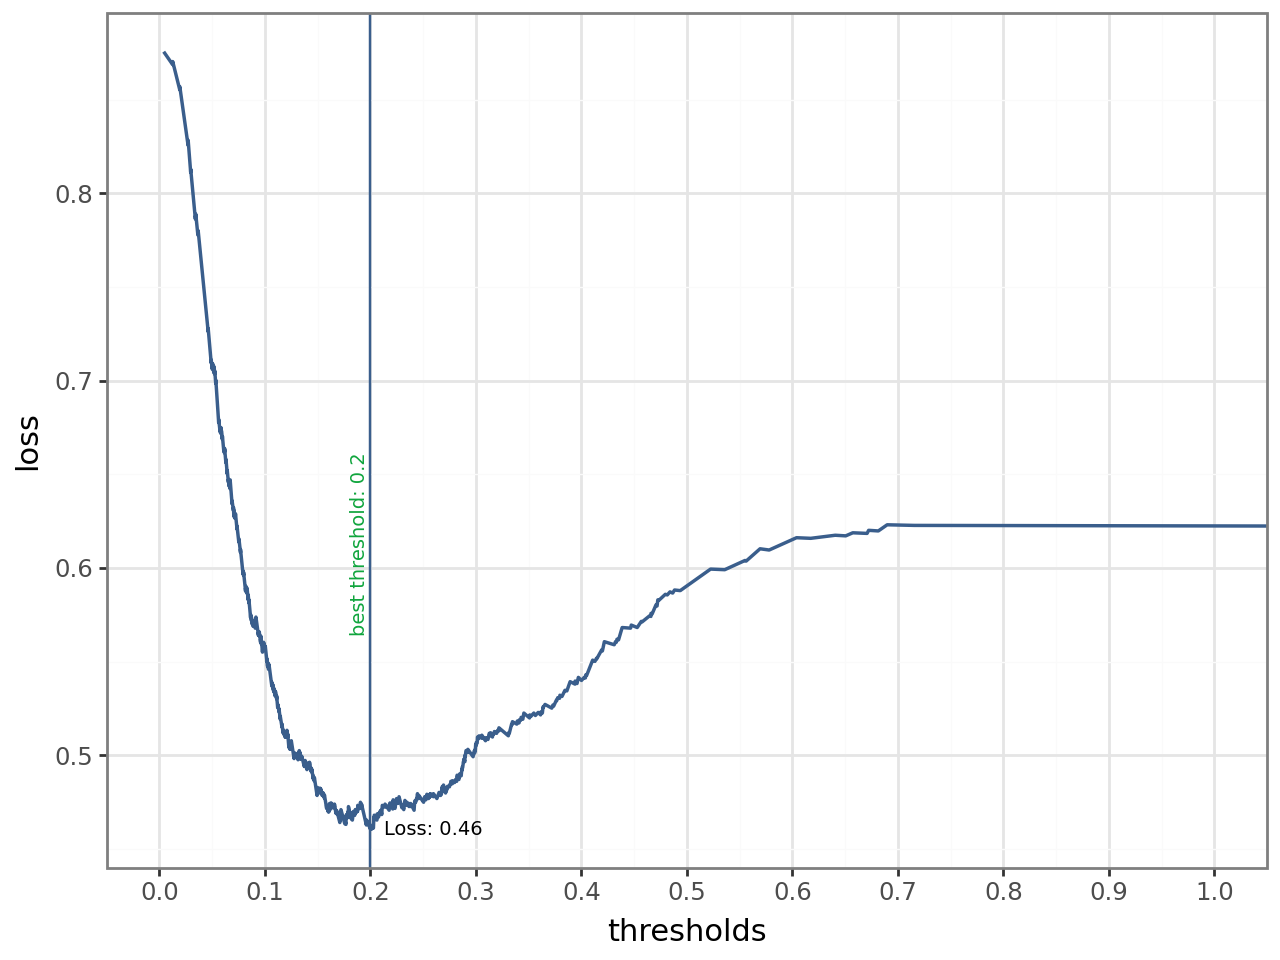

In [175]:
create_loss_plot(
    fold5_all_coords['prob_forest'],
    fold5_threshold['prob_forest'],
    fold5_expected_loss['prob_forest'],
)


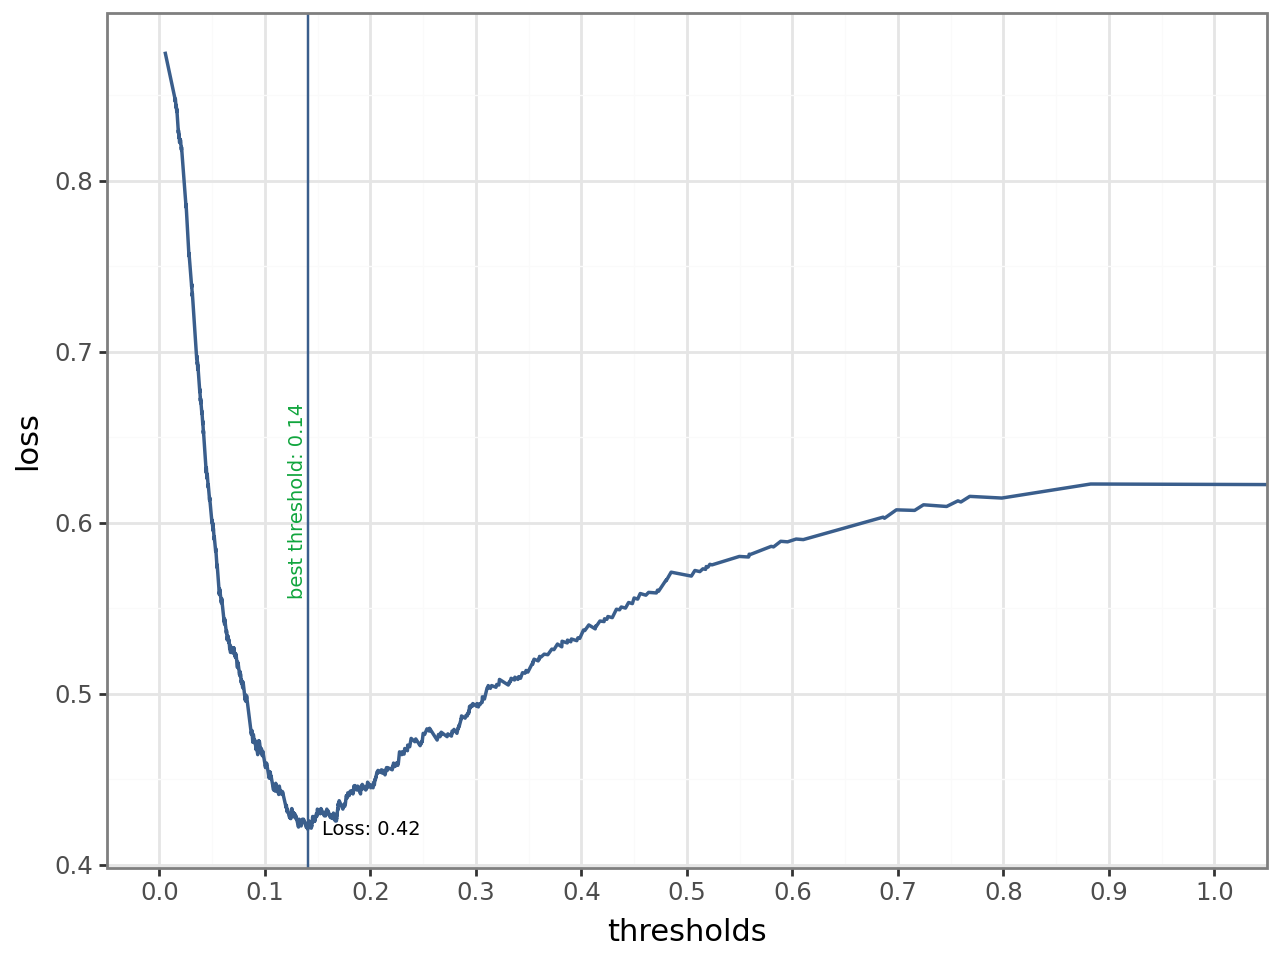

In [176]:
create_loss_plot(
    fold5_all_coords['prob_xgb'],
    fold5_threshold['prob_xgb'],
    fold5_expected_loss['prob_xgb'],
)


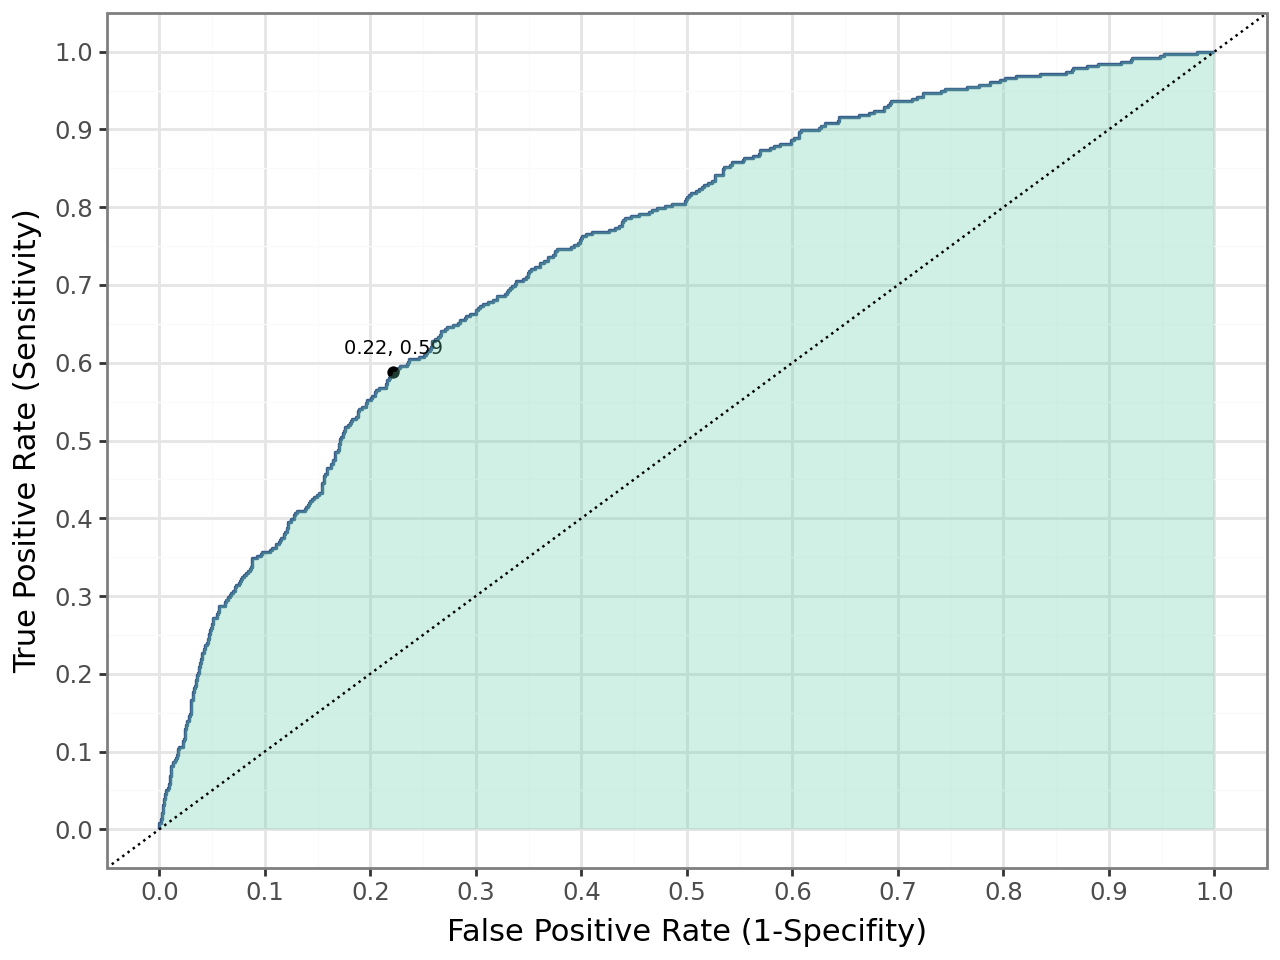

In [177]:
create_roc_plot_with_optimal(fold5_all_coords['lasso_logit'], fold5_threshold['lasso_logit'])

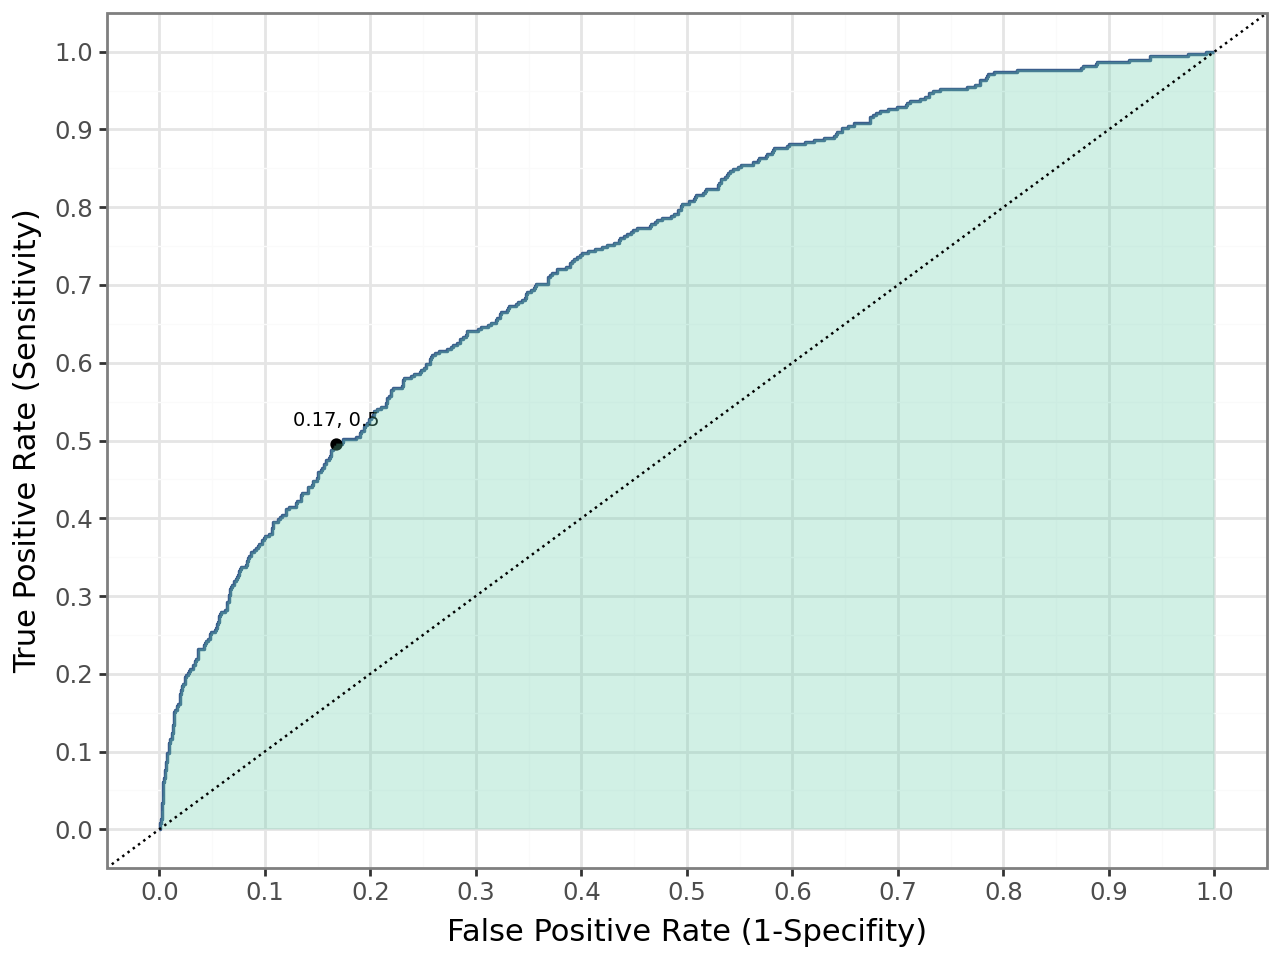

In [178]:
create_roc_plot_with_optimal(fold5_all_coords['prob_forest'], fold5_threshold['prob_forest'])

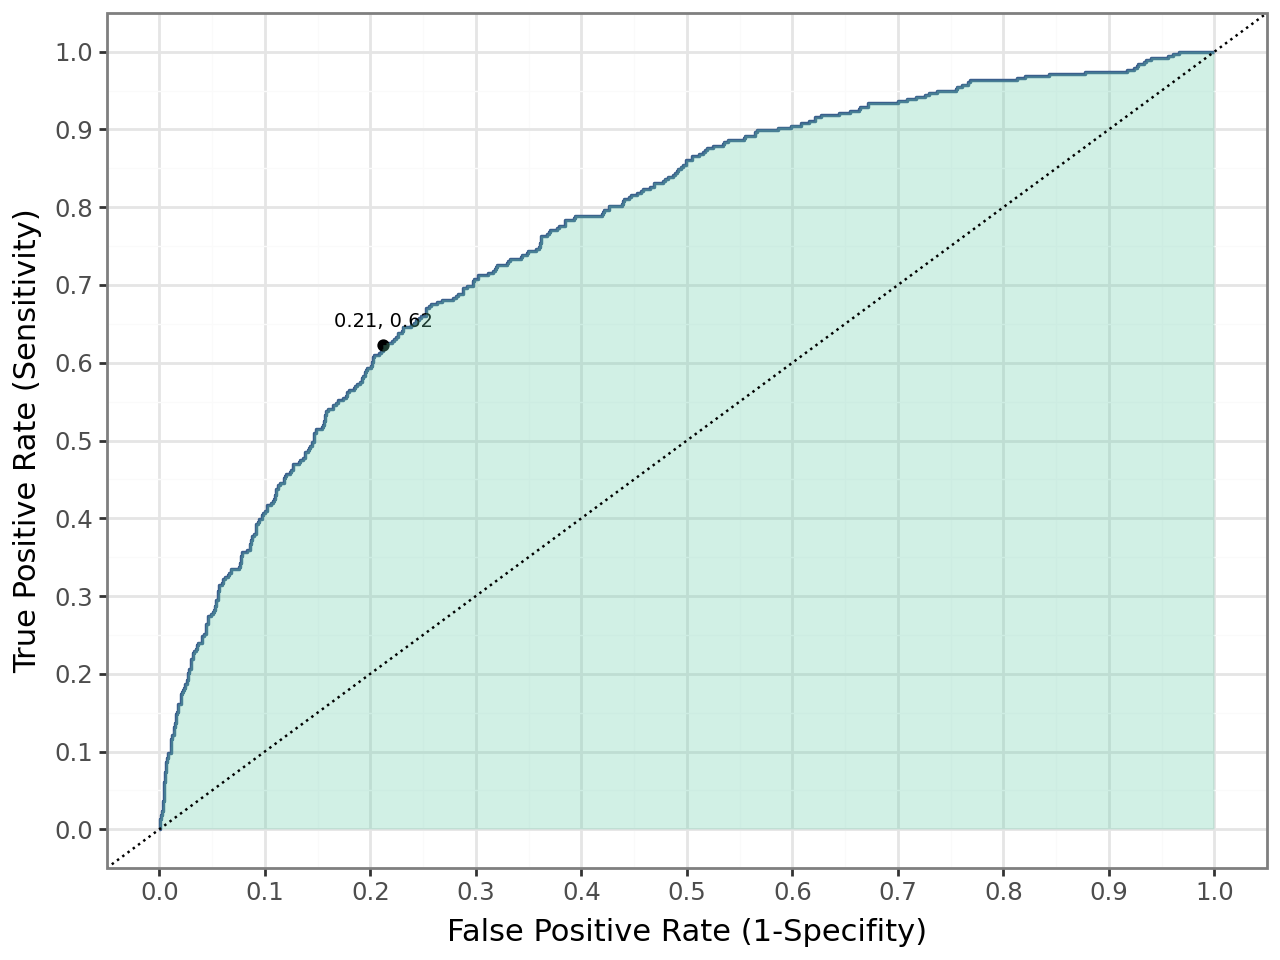

In [179]:
create_roc_plot_with_optimal(fold5_all_coords['prob_xgb'], fold5_threshold['prob_xgb'])

In [190]:
pred_dc = {
    'lasso_logit' : {
        'full_name' : 'LASSO logit',
        'pred_col' : 'lasso_pred',
        'threshold' : best_thresholds_cv['lasso_logit']
    },
    'prob_forest' : {
        'full_name' : 'Prob. forest',
        'pred_col' : 'rf_pred',
        'threshold' : best_thresholds_cv['prob_forest']
    },
    'prob_xgb' : {
        'full_name' : 'Prob. XGB',
        'pred_col' : 'xgb_pred',
        'threshold' : best_thresholds_cv['prob_xgb']
    }
}

hold_out_loss = dict()

In [192]:
for name, dc in pred_dc.items():
    print(f'Hold-out set classification results for: {dc["full_name"]}')

    holdout_treshold = np.where(hold_out_predictions[dc['pred_col']] < dc['threshold'], 0, 1)
    tn, fp, fn, tp = confusion_matrix(hold_out_predictions['b_fast_growth_true'], holdout_treshold, labels=[0, 1]).ravel()
    expected_loss_holdout = (fp * FP + fn * FN) / len(hold_out_predictions['b_fast_growth_true'])

    print(f'Expected loss on hold-out set: {expected_loss_holdout:.4f}')

    hold_out_loss[dc['full_name']] = expected_loss_holdout
    
    cm = confusion_matrix(hold_out_predictions['b_fast_growth_true'], holdout_treshold, labels=[0, 1])
    cm = pd.DataFrame(
        cm,
        index=["Actul no fast growth", "Actual fast growth"],
        columns=["Predicted no fast growth", "Predicted fast growth"],
    )

    print(f'Confusion matrix for the hold-out set:')
    display(cm)

Hold-out set classification results for: LASSO logit
Expected loss on hold-out set: 0.4651
Confusion matrix for the hold-out set:


,Predicted no fast growth,Predicted fast growth
Actul no fast growth,2774,561
Actual fast growth,242,231


Hold-out set classification results for: Prob. forest
Expected loss on hold-out set: 0.4598
Confusion matrix for the hold-out set:


,Predicted no fast growth,Predicted fast growth
Actul no fast growth,2789,546
Actual fast growth,241,232


Hold-out set classification results for: Prob. XGB
Expected loss on hold-out set: 0.4475
Confusion matrix for the hold-out set:


,Predicted no fast growth,Predicted fast growth
Actul no fast growth,2656,679
Actual fast growth,205,268


In [204]:
full_summary = summary_with_lossfnc.merge(
    pd.DataFrame(hold_out_loss.items(), columns=['Model', 'Hold-out loss']),
    on='Model'
).merge(
    prob_summary,
    left_on='Model',
    right_index=True
)

full_summary = full_summary.filter(
    ['Model', 'Time (min)', 'CV RMSE', 'Hold-out RMSE', 'CV AUC', 'Hold-out AUC', 'Avg. of optimal thresholds', 'Avg. expected loss', 'Hold-out loss']
)

full_summary.rename(
    columns={
        'Avg. of optimal thresholds' : 'CV class. threshold',
        'Avg. expected loss' : 'CV expected loss',
    }, inplace=True
)

full_summary

,Model,Time (min),CV RMSE,Hold-out RMSE,CV AUC,Hold-out AUC,CV class. threshold,CV expected loss,Hold-out loss
0,LASSO logit,2.99,0.3121,0.3118,0.7483,0.7444,0.18680,0.448645,0.465074
1,Prob. forest,11.29,0.3111,0.3096,0.7485,0.7446,0.20146,0.453374,0.459821
2,Prob. XGB,20.86,0.3080,0.3060,0.7662,0.7627,0.14854,0.436759,0.447479


Based on a quick Google search of the NACE system, the 2-digit codes of 33 (repairs), 55 (hospitality) and 56 (restaurants) belong to the services industry, while the rest of the codes to manufacturing.

In [217]:
data_train_serv = data_train[data_train['f_ind2_cat'].isin([33,55,56])]
data_train_manu = data_train[~data_train['f_ind2_cat'].isin([33,55,56])]

data_holdout_serv = data_holdout[data_holdout['f_ind2_cat'].isin([33,55,56])]
data_holdout_manu = data_holdout[~data_holdout['f_ind2_cat'].isin([33,55,56])]

In [222]:
for d in [data_train_serv, data_train_manu, data_holdout_serv, data_holdout_manu]:
    for col in d.select_dtypes(include=["category"]).columns:
        d[col] = d[col].cat.remove_unused_categories()